In [1]:
%matplotlib inline

In [2]:
import matplotlib.cm as cm
from matplotlib import lines as mlines

In [3]:
import fsps

LSST_BANDS = fsps.filters.find_filter('lsst')
filter_wave_collector = [fsps.filters.get_filter(band).transmission[0] for band in LSST_BANDS]
filter_trans_collector = [fsps.filters.get_filter(band).transmission[1] for band in LSST_BANDS]

def get_mags_and_spec(Av, zmet_indx=20):
    _sp = fsps.StellarPopulation(zcontinuous=0, zmet=zmet_indx, dust_type=2, dust2=Av, add_dust_emission=False)
    _wave, _fluxes = _sp.get_spectrum(peraa=True)
    _mags = _sp.get_mags(bands=LSST_BANDS)
    return _wave, _fluxes, _mags


In [14]:
avray = [0, 0.1, 0.25, 0.5, 1, 2, 4, 10]
results = [get_mags_and_spec(av) for av in avray]
spec_results = np.array([results[i][1] for i, av in enumerate(avray)])
mag_results = np.array([results[i][2] for i, av in enumerate(avray)])

wave_spec = results[0][0]

In [5]:
from dsps.attenuation_kernels import _flux_ratio, calzetti00_k_lambda, RV_C00

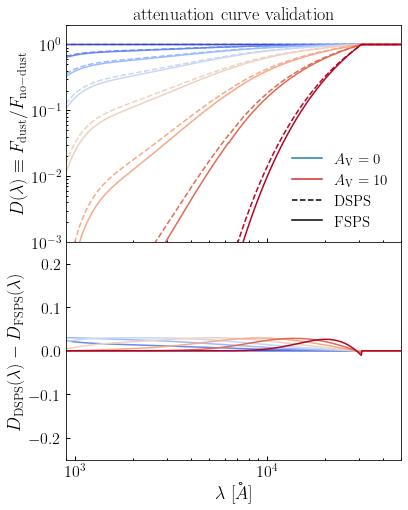

In [18]:
colors=cm.coolwarm(np.linspace(0, 1, len(avray))) # red first
label_pat = "Av = {0:.2f}"

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
# fig.tight_layout(pad=3.0)
fig.subplots_adjust(hspace=0)
xlim = ax0.set_xlim(900, 5e4)
ylim = ax0.set_ylim(1e-3, 2)
ylim = ax1.set_ylim(-.25, 0.25)
__=ax0.loglog()
dsps_attenuation_collector = []

for iav, av in enumerate(avray):
    iage = 80
    fsps_flux_ratio = spec_results[iav, iage, :] / spec_results[0, iage, :]
    __=ax0.plot(wave_spec, fsps_flux_ratio, color=colors[iav])
    
    
    wave_spec_micron = wave_spec/10_000
    k = calzetti00_k_lambda(wave_spec_micron, RV_C00)
    dsps_flux_ratio = _flux_ratio(k, RV_C00, av)
    __=ax0.plot(wave_spec, dsps_flux_ratio, '--', color=colors[iav])
    dsps_attenuation_collector.append(dsps_flux_ratio)

    __=ax1.plot(wave_spec, (dsps_flux_ratio - fsps_flux_ratio), color=colors[iav])
    
title = ax0.set_title(r'${\rm attenuation\ curve\ validation}$')
title = ax0.set_ylabel(r'$D(\lambda)\equiv F_{\rm dust}/F_{\rm no-dust}$')
xlabel = ax1.set_xlabel(r'$\lambda\ [\AA]$')
xlabel = ax1.set_ylabel(r'$D_{\rm DSPS}(\lambda)-D_{\rm FSPS}(\lambda)$')


red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$A_{\rm V}=10$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$A_{\rm V}=0$')
solid_line=mlines.Line2D([],[],ls='-',c='k',label=r'${\rm FSPS}$')
dashed_line=mlines.Line2D([],[],ls='--',c='k',label=r'${\rm DSPS}$')
first_legend=ax0.legend(handles=[blue_line, red_line, dashed_line, solid_line])
fig.savefig('dsps_attenuation_validation.png', bbox_extra_artists=[xlabel], bbox_inches='tight', dpi=200)